# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os
from pathlib import Path
from random import random

import pandas as pd
#import dask.dataframe as dd # https://docs.dask.org/en/latest/dataframe.html
import numpy as np

from Bio import SeqIO

import matplotlib.pyplot as plt
import seaborn as sns

# Train dataset (Challenge reference genomes)

## Data frame setup

### Read fasta files into df

In [3]:
PATH_REF = Path('ChallengeRefGenomes')

In [3]:
# based on https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/08_data_block.ipynb
def get_files(path, extension='.fasta'):
    path = Path(path)
    fs = [f for f in os.scandir(path) if (not str(f).startswith('.') and f.name.endswith(extension))]
    return fs

In [5]:
def get_fasta_df(path, extension='.fasta'):
    seq, lbs = [], []
    for f in get_files(path, extension=extension):
        for rec in SeqIO.parse(f, 'fasta'):
            seq.append(str(rec.seq.upper())) # append sequence
            lbs.append(str(rec.name)) # append sequence name
    df = pd.DataFrame({'label': lbs, 'sequence': seq})
    assert df.isna().sum().sum() == 0 # check for NaN values
    assert df.duplicated().sum() == 0 # check for duplicates
    return df

In [6]:
df = get_fasta_df(PATH_REF)

In [7]:
df.shape

(1694, 2)

In [9]:
df.head()

label                                           sequence
0  CR_443_Contig_0  ATCCAATTATTGGTAAAAGAAAATAAAAATTTTATAAGCGGCGTGC...
1  CR_494_Contig_0  AAACGTGGAGCACTTACTGGCTCGAAAGAAAGCGTGATCATCGCAT...
2  CR_494_Contig_1  ATTGACTGCTCATTTATGGGTCATGAAGAGTCTCTGATGTTGTTTT...
3  CR_494_Contig_2  AACTTGAAGCCGTCTTTACGGATTAGCGTTGTCACGCAGGCTTTGT...
4  CR_494_Contig_3  TGATTTCGCCCATAATATTGGCGTCAGCATGGTTATCGGCAATTAT...

In [10]:
# save df as csv file
df.to_csv('ChallengeRefGenomes.csv', index=False)

### Test load df

In [ ]:
df = pd.read_csv('ChallengeRefGenomes.csv')

In [ ]:
df.shape

In [ ]:
df.head()

## Exploratory data analysis (EDA)

### Calculate contig total base pair length and count

In [5]:
df = pd.read_csv('ChallengeRefGenomes.csv')

In [6]:
# get only genome name
df['species'] = df['label'].apply(lambda x: x.split('_')[1])

In [7]:
# get sequence length
df['length'] = df['sequence'].apply(lambda x: len(x))

In [8]:
df['length'].sum()

2050889780

In [9]:
# total sequence length in bp
total_length = df['length'].sum()
print(f'{total_length:.2e}')

2.05e+09


In [10]:
df.describe()

length
count  1.694000e+03
mean   1.210679e+06
std    1.745196e+06
min    2.500000e+02
25%    1.895825e+04
50%    1.135795e+05
75%    2.261265e+06
max    8.934655e+06

In [11]:
#df.describe(include=['O'])

In [12]:
df.head()

label                                           sequence species  \
0  CR_443_Contig_0  ATCCAATTATTGGTAAAAGAAAATAAAAATTTTATAAGCGGCGTGC...     443   
1  CR_494_Contig_0  AAACGTGGAGCACTTACTGGCTCGAAAGAAAGCGTGATCATCGCAT...     494   
2  CR_494_Contig_1  ATTGACTGCTCATTTATGGGTCATGAAGAGTCTCTGATGTTGTTTT...     494   
3  CR_494_Contig_2  AACTTGAAGCCGTCTTTACGGATTAGCGTTGTCACGCAGGCTTTGT...     494   
4  CR_494_Contig_3  TGATTTCGCCCATAATATTGGCGTCAGCATGGTTATCGGCAATTAT...     494   

    length  
0    11477  
1    19511  
2    29108  
3   622989  
4  3944186

In [ ]:
# save df as csv file
df.to_csv('ChallengeRefGenomes_ext.csv', index=False)

### Contig lengths and counts

In [58]:
# save df as csv file
df = pd.read_csv('ChallengeRefGenomes_ext.csv')

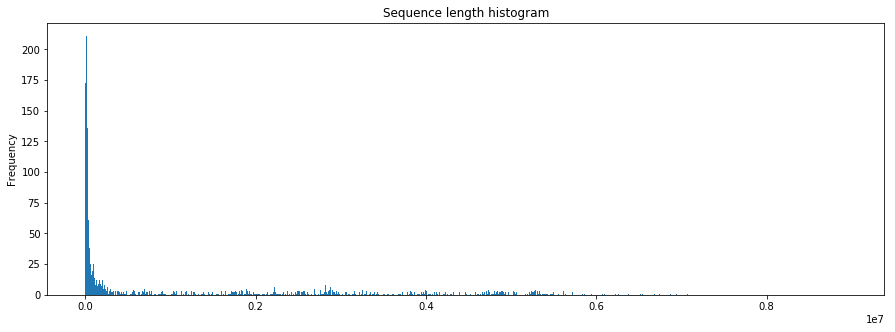

In [60]:
df['length'].plot(kind='hist', figsize=(15,5), bins=1000, title='Sequence length histogram');
#range=[0, 1e7], 

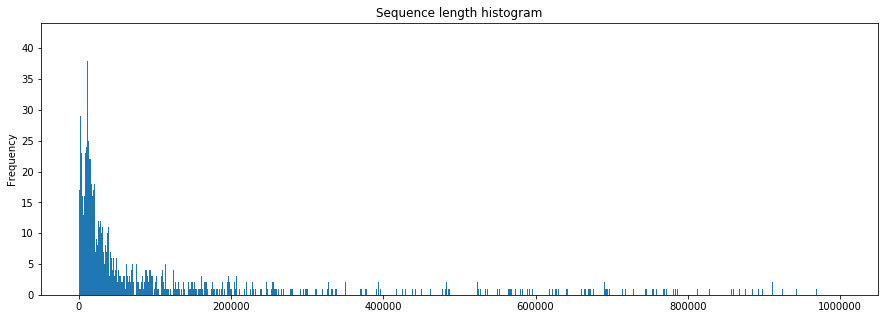

In [61]:
df['length'].plot(kind='hist', bins=1000, range=[0, 1e6], figsize=(15,5), title='Sequence length histogram'); 

In [62]:
# get the total contig length of the sequences per species
df_pv = pd.pivot_table(df, values='length', index='species', aggfunc='sum').sort_values(by='length', ascending=False)

In [63]:
# calculate the percentage of the contig length of the sequences per species in %
df_pv['length_percentage'] = df_pv['length']/df_pv['length'].sum()*100

In [64]:
#  add contig count
df_pv['contig_count'] = pd.pivot_table(df, values='length', index='species', aggfunc='count').sort_values(by='length', ascending=False)

In [65]:
df_pv.head(10)

length  length_percentage  contig_count
species                                           
195      35796027           1.745390            25
487      34011430           1.658374            71
475      33443056           1.630661            56
73        9009338           0.439289             7
319       8934655           0.435648             1
37        8890828           0.433511             5
398       8809615           0.429551             4
143       8613087           0.419968             5
428       8569715           0.417854             4
193       8379432           0.408575             4

In [66]:
df_pv.tail(10)

length  length_percentage  contig_count
species                                         
406       11276           0.000550             1
445       11256           0.000549             1
15        11142           0.000543             2
74        10772           0.000525             1
59        10771           0.000525             1
208       10771           0.000525             1
210       10709           0.000522             3
425       10493           0.000512             2
125       10368           0.000506             1
124        9899           0.000483             3

We have 517 different species and the species with the highest contig lentgh percentage has only 1,75% of the total contig length.

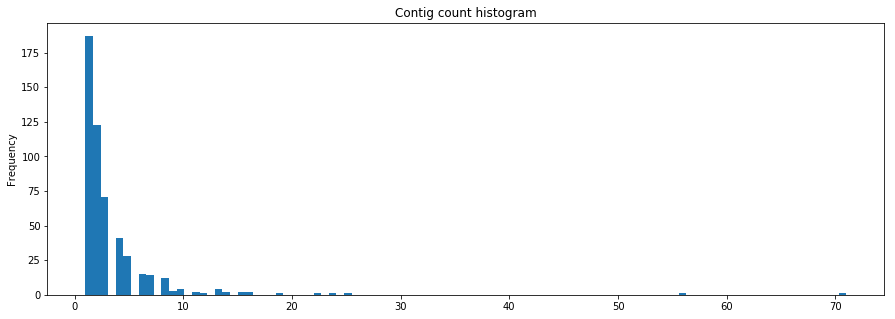

In [67]:
df_pv['contig_count'].plot(kind='hist', bins=100, figsize=(15,5), title='Contig count histogram');

In [72]:
df_pv.to_csv('ChallengeRefGenomes_ext_species_length.csv', index=False)

### Figure total contig base pair length and contig count per species

In [4]:
df_pv = pd.read_csv('ChallengeRefGenomes_ext_species_length.csv')

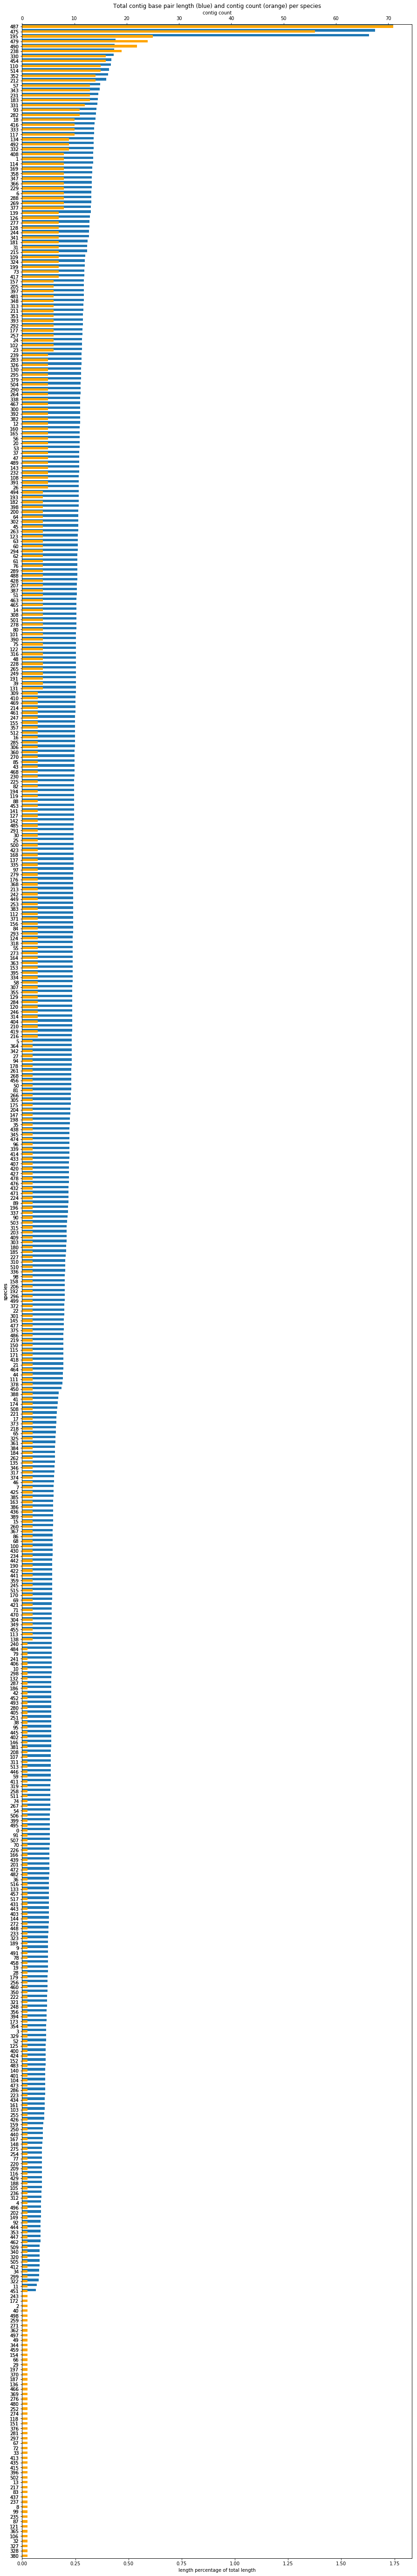

In [101]:
fig, ax1 = plt.subplots(figsize=(15,100))
ax1.set_title('Total contig base pair length (blue) and contig count (orange) per species')
df_pv['length_percentage'].sort_values().plot.barh(ax=ax1, align='edge')
ax1.set_xlabel('length percentage of total length')
ax2 = ax1.twiny()
df_pv['contig_count'].sort_values().plot.barh(ax=ax2, align='center', color='orange')
ax2.set_xlabel('contig count')
plt.show();

The higher the contig sequence count the higher the total contig sequence base pair sum.

### Split sequences into smaller fragments

In [74]:
# tokenizer crashes when the sequences above 1e6 bp are included, 
# therefore, we cut sequences longer than 1e6 into 1e6 parts

In [102]:
n = 1000 #int(1e6)

In [103]:
# Disamble and assemble df to have sequences in max n bp per row
# based on https://mikulskibartosz.name/how-to-split-a-list-inside-a-dataframe-cell-into-rows-in-pandas-9849d8ff2401

def split_seq(df, n):
    
    start_len = len(df)
    
    label = []
    sequence = []
    species = []
    length = []

    for _, row in df.iterrows():    
        if row.length < n:
            label.append(row.label)
            sequence.append(row.sequence)
            species.append(row.species)
            length.append(row.length)
        else:
            sqs = [row.sequence[i:i+n] if i+n < row.length else row.sequence[i:] for i in range(0, row.length, n)]

            for sq in sqs:
                label.append(row.label)
                sequence.append(sq)
                species.append(row.species)
                length.append(row.length)

    df = pd.DataFrame({'label': label, 'sequence': sequence, 'species': species, 'length_orig': length})
    df['length'] = df['sequence'].apply(lambda x: len(x))
    
    # check if there are sequences longer than n
    assert df[df['length'] > n].sum().sum() == 0
    
    end_len = len(df)
    
    print(f'df row count changed by {(end_len-start_len)/start_len*100:.2f}% \n({end_len} vs. {start_len})')
    
    return df


In [104]:
df = split_seq(df, n)

df row count changed by 121017.71% 
(2051734 vs. 1694)


In [105]:
df.tail()

label                                           sequence  \
2051729  CR_89_Contig_1  AGATGGGCGGATTTCCACACAGCACCTTGCCCGGCAAGGTGGGCCG...   
2051730  CR_89_Contig_1  GCGGCAGCGGCGCCCGGCAAGGTGGGCCGATTCCCATATCGACATG...   
2051731  CR_89_Contig_1  CTCAGAAGCCTTCCCGGGCCTTATCCGGCAGACTCACAGAAAAATC...   
2051732  CR_89_Contig_1  GATCGGCGACAACGTCACCCGCCTTGACCGCTGGGAAACGGAACTG...   
2051733  CR_89_Contig_1  CCGCAGCCAGCCGGCTGACGGCGCGCACGCCGCCCGAGACGCTGAC...   

         species  length_orig  length  
2051729       89        79084    1000  
2051730       89        79084    1000  
2051731       89        79084    1000  
2051732       89        79084    1000  
2051733       89        79084      84

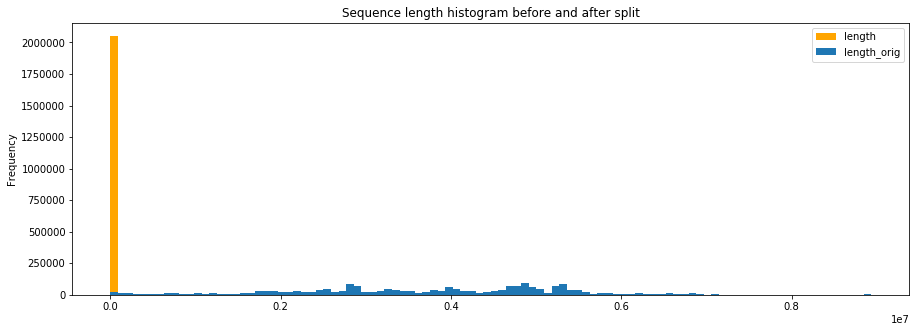

In [112]:
df[['length', 'length_orig']].plot(kind='hist', bins=100, color=['orange', 'C0'], figsize=(15,5), title='Sequence length histogram before and after split');
#range=[0, 1e7], 

In [3]:
#df['length'].plot(kind='hist', bins=100, color='orange', figsize=(15,5), title='Sequence length histogram after split');

In [81]:
df.shape

(2051734, 5)

In [82]:
# remove sequences smaller than 10 bp
df = df[df['length'] > 10]

In [83]:
df.shape

(2051720, 5)

In [84]:
assert df[df['length'] < 10].sum().sum() == 0

In [85]:
df.to_csv('ChallengeRefGenomes_ext_split_1e3.csv', index=False)

### blastn WIP

In [ ]:
# concatenate all raw fasta files into one file
#! cat CR_*.fasta > allseq.fasta

[Linkt to file](/files/Documents/UGenoMFiT/ChallengeRefGenomes/test.fasta)

In [ ]:
# https://github.com/nspies/genomeview ?

## Train and valid data set split

In [169]:
df = pd.read_csv('ChallengeRefGenomes_ext_split_1e3.csv')

In [170]:
p_valid = 0.3 # 30% for valid and test set

In [171]:
# mark df rows with a probability p_valid for the valid and test set
df['valid'] = [0 if random() > p_valid else 1 for _ in range(len(df))]

In [172]:
# check valid and test set rows percentage
df['valid'].mean()

0.30022517692472656

In [173]:
p_test_valid = 0.33 # 33% of the 30% are 10% for the test set

In [174]:
# create test col with 0
df['test'] = 0

In [175]:
# mark valid set rows with a probability p_test_valid for the test set
df.loc[df['valid'] == 1, ['test']] = [0 if random() > p_test_valid else 1 for _ in range(len(df[df['valid'] == 1]))]

In [176]:
# check test set rows percentage
df['test'].mean()

0.09886972881289845

In [177]:
# set the valid rows for test rows to zero (a row in the test set should not be part of the valid set)
df.loc[df['test'] == 1, ['valid']] = 0

In [178]:
# check valid set rows percentage after removing test set rows
df['valid'].mean()

0.20135544811182812

In [179]:
# check total valid and test rows percentage, should equal p_test_valid
df['valid'].mean() + df['test'].mean()

0.30022517692472656

### Search for species not in the valid or test set

In [180]:
# get the total contig length of the sequences per species in the train dataset
df_pv_train = pd.pivot_table(df[df['valid'] == 0], values='length', index='species', aggfunc='sum').sort_values(by='length', ascending=False)

In [181]:
# get the total contig length of the sequences per species in the valid dataset
df_pv_valid = pd.pivot_table(df[df['valid'] == 1], values='length', index='species', aggfunc='sum').sort_values(by='length', ascending=False)

In [182]:
# get the total contig length of the sequences per species in the valid dataset
df_pv_test = pd.pivot_table(df[df['test'] == 1], values='length', index='species', aggfunc='sum').sort_values(by='length', ascending=False)

In [183]:
df_train_split = pd.concat((df_pv_train['length'], df_pv_valid['length'], df_pv_test['length']), axis=1)

In [184]:
df_train_split.columns = ['length train', 'length valid', 'length test']

In [185]:
df_train_split = df_train_split.sort_values(by='length train', ascending=True)

In [187]:
df_train_split[df_train_split['length valid'].isnull()]

length train  length valid  length test
species                                         
125             10368           NaN       3000.0
287             11327           NaN          NaN

In [188]:
df_train_split[df_train_split['length test'].isnull()]

length train  length valid  length test
species                                         
210              5618        5091.0          NaN
425              6108        4385.0          NaN
298              7000        4285.0          NaN
59               7771        3000.0          NaN
74               8000        2772.0          NaN
406              8276        3000.0          NaN
186              8414        3000.0          NaN
9                8839        3000.0          NaN
69               9253        3000.0          NaN
511             10742        8000.0          NaN
287             11327           NaN          NaN
439             13958        5000.0          NaN
166             16957        2000.0          NaN

### Manually optimize valid and test set

In [197]:
df.loc[df['species'] == 125]

label                                           sequence  \
870726  CR_125_Contig_0  TGAGTTTGAAGCGAAAGCTAGCAACAGTATCAACAGGTTTTATTTT...   
870727  CR_125_Contig_0  GGGTTGATGTTGTCTTGGAACATGGAGGTTGTGTCACCGTAATGGC...   
870728  CR_125_Contig_0  CCCAGTTGGGAGGTTGATAACCGCTAACCCCGTAATCACTGAAAGC...   
870729  CR_125_Contig_0  GTTATTGGAACAGCTGTTAAGGGAAAGGAGGCTGTACACAGTGATC...   
870730  CR_125_Contig_0  GCACACTGCTTGTGGCGTGGAGAGCAGGCCTTGCTACTTGCGGGGG...   
870731  CR_125_Contig_0  CAAGTGTGGGAGAGTGATAGGACTTTATGGCAATGGGGTCGTGATC...   
870732  CR_125_Contig_0  GGTGGGTGCGCAGAGACTGACGAAGACCATGCACACTGGCTTGAAG...   
870733  CR_125_Contig_0  CCATCTATGCTGCCTTGACAACTTTCATTACCCCAGCCGTCCAACA...   
870734  CR_125_Contig_0  AGTCCGTCTTAAGAGTGGGGTGGACGTCTTTCATATGGCGGCTGAG...   
870735  CR_125_Contig_0  GGAAAAAGAGAAAAGAAACAAGGGGAATTTGGAAAGGCCAAGGGCA...   
870736  CR_125_Contig_0  TTCCAACTGGGAGAACTACCTGGTCAATCCATGGAAAGGGAGAATG...   

        species  length_orig  length  valid  test  
870726      125        10368    1000      0     1  
870727      125        10368    1000      0     0  
870728      125        10368    1000      0     0  
870729      125        10368    1000      0     0  
870730      125        10368    1000      0     0  
870731      125        10368    1000      0     0  
870732      125        10368    1000      0     1  
870733      125        10368    1000      0     0  
870734      125        10368    1000      0     0  
870735      125        10368    1000      0     1  
870736      125        10368     368      0     0

In [204]:
# manually pick three rows for the valid data set
df.loc[[870727, 870730, 870733], 'valid'] = 1

In [206]:
df.loc[df['species'] == 287]

label                                           sequence  \
300683  CR_287_Contig_0  CTTTGTGTTTGATTGCTGTCGTAATTTGCTCTACATATATTTTGCA...   
300684  CR_287_Contig_0  TTCAGCTGTGCCTGGACAGATGCGGTGTGTGCCTTGTATGCCGTGG...   
300685  CR_287_Contig_0  AACCAAAACGCAGCACGGGCTCAGGGGCTAATGGCACAGTGCACTT...   
300686  CR_287_Contig_0  GGTGGTAATCAAAGACCACTGTTCACAATTTTCCGGTGTATATTTG...   
300687  CR_287_Contig_0  CCACTGCCTTACACAACTCAGCGAAGATACCTACTCGACACCACCG...   
300688  CR_287_Contig_0  ATACTCCTGATTGCAGGCAAATTTCTTAAAGCATTCCACATTAAAT...   
300689  CR_287_Contig_0  GTACTTGCGCTAGCTCTCGAACTGGCCTGCGATTGATTGGCACTAC...   
300690  CR_287_Contig_0  CTGCAAAAATTCCTGTGGACAACAAGGGGATGGCTACGGACTGGTA...   
300691  CR_287_Contig_0  CCTCGGCAATTGAGGGTACCGACGGGCCAGTTGCCGAACCACTTCC...   
300692  CR_287_Contig_0  CATCCATTGAGCAATACAGAGTCCACAGTGCGTGCTATCACATCTA...   
300693  CR_287_Contig_0  GCACTTTGACAATGGTTTGGGTGTCTGGTTTTTTGTAGACGGAGGT...   
300694  CR_287_Contig_0  CTTGTCAGTTATGTCTTTGCAGTTCTTCTTTAATTTGGATGCATAC...   

        species  length_orig  length  valid  test  
300683      287        11327    1000      0     0  
300684      287        11327    1000      0     0  
300685      287        11327    1000      0     0  
300686      287        11327    1000      0     0  
300687      287        11327    1000      0     0  
300688      287        11327    1000      0     0  
300689      287        11327    1000      0     0  
300690      287        11327    1000      0     0  
300691      287        11327    1000      0     0  
300692      287        11327    1000      0     0  
300693      287        11327    1000      0     0  
300694      287        11327     327      0     0

In [208]:
# manually pick three rows for the valid data set
df.loc[[300686, 300691, 300693], 'valid'] = 1

In [209]:
# manually pick three rows for the test data set
df.loc[[300684, 300687, 300690], 'test'] = 1

In [212]:
df_train_split[df_train_split['length test'].isnull()]

length train  length valid  length test
species                                         
210              5618        5091.0          NaN
425              6108        4385.0          NaN
298              7000        4285.0          NaN
59               7771        3000.0          NaN
74               8000        2772.0          NaN
406              8276        3000.0          NaN
186              8414        3000.0          NaN
9                8839        3000.0          NaN
69               9253        3000.0          NaN
511             10742        8000.0          NaN
287             11327           NaN          NaN
439             13958        5000.0          NaN
166             16957        2000.0          NaN

In [213]:
df.loc[df['species'] == 210]

label                                           sequence  \
1692573  CR_210_Contig_0  AGATGGGCCGTGACTGTGAACGAGCTGCACAACGGCTGGAAGGCTG...   
1692574  CR_210_Contig_1  TGACTAAGACTGCGACAGTTCGAGTTTGAAGCGAAAGCTAGCAACA...   
1692575  CR_210_Contig_1  AGGTATGTCAGGTGGGACTTGGGTTGATGTCGTCTTGGAACATGGA...   
1692576  CR_210_Contig_1  GTGGACATGCAAACTCTGACCCCAGTTGGGAGGTTGATAACCGCTA...   
1692577  CR_210_Contig_1  CATTAGAGTGTGATCCAGCCGTTATTGGAACAGCTGTTAAGGGAAA...   
1692578  CR_210_Contig_1  TCTGACACCACTGGCCCGGGGCACACTGCTTGTGGCGTGGAGAGCA...   
1692579  CR_210_Contig_1  TCAGGATCTCCAATCCTAGACAAGTGTGGGAGAGTGATAGGACTTT...   
1692580  CR_210_Contig_1  GAGATGAGTATCTGTATGGAGGTGGGTGCGCAGAGACTGACGAAGA...   
1692581  CR_210_Contig_1  GCGGCCAGCCTCAGCTTGGGCCATCTATGCTGCCTTGACAACTTTC...   
1692582  CR_210_Contig_1  CAAAGCTATGGGTGGAACATAGTCCGTCTTAAGAGTGGGGTGGACG...   
1692583  CR_210_Contig_2  GCTGTGCCTCGCTAGCAGGCCTGACAACATTAAGATTGGTGCTTAC...   
1692584  CR_210_Contig_2  GCTGGTCTAAGGACCTTTACCACTTTGTTTTGGTATGTGTACTTGA...   
1692585  CR_210_Contig_2  TCACTGGCCTCCTAGGCCCGTCCATGCGCCCCAAGAGGAGCTGGCT...   

         species  length_orig  length  valid  test  
1692573      210          389     389      0     0  
1692574      210         8229    1000      0     0  
1692575      210         8229    1000      1     0  
1692576      210         8229    1000      0     0  
1692577      210         8229    1000      0     0  
1692578      210         8229    1000      0     0  
1692579      210         8229    1000      1     0  
1692580      210         8229    1000      1     0  
1692581      210         8229    1000      1     0  
1692582      210         8229     229      0     0  
1692583      210         2091    1000      0     0  
1692584      210         2091    1000      1     0  
1692585      210         2091      91      1     0

In [214]:
# manually pick three rows for the test data set
df.loc[[1692577, 1692582], 'test'] = 1

In [215]:
df.loc[df['species'] == 425]

label                                           sequence  \
484309  CR_425_Contig_0  TTCTCCTTTCTTCTTCCCGTTCTGATTCCGCTGAACCGGTTGGCGC...   
484310  CR_425_Contig_0  ACCACGCATGCATACCCGTTAGTTCTCCCCTCAAGCATGATGGGAA...   
484311  CR_425_Contig_0  TTTCATCATGGCTCCAAACTTGAATTTAGTTTTGGTCGGCAGGTGA...   
484312  CR_425_Contig_0  GCAAGATGCTCCGTCCACCATATCCAGATACGCATCGTACTCCGGC...   
484313  CR_425_Contig_0  ATACTAGGTGCTGACCCATCAGCGTCCACCGCCTGGGCGACTGTTG...   
484314  CR_425_Contig_0  CGCGGCTGTTAGCCGCGTTTACAATCACTCCCTCTTCCGCCAAGGC...   
484315  CR_425_Contig_0  CCTGAGAATGGGCACCAGCGCCTTAGCCCAGCAGACGTTCGCTTTG...   
484316  CR_425_Contig_0  CGGCCAGCCCCAGCCCGTGCACTTGGTCTTTCTTGACACACTGCTT...   
484317  CR_425_Contig_0  AGCGTCGTCTGCACTGACATCTGTAGCCAGTATTCCGGTCATCTGG...   
484318  CR_425_Contig_0  AAGCTCCGTTGCAAAGCTCTGAGGAATGGGCTATCCTCCTCGATAT...   
484319  CR_425_Contig_1  CACGCGACTACGATGCCGAATCAGGTGGGCATCCCATATAACACCA...   
484320  CR_425_Contig_1  CGGCGACTCTGAAGGAGTCGATCGTCGATCTAACCGCGGAGGGGAC...   

        species  length_orig  length  valid  test  
484309      425         9108    1000      1     0  
484310      425         9108    1000      0     0  
484311      425         9108    1000      1     0  
484312      425         9108    1000      0     0  
484313      425         9108    1000      0     0  
484314      425         9108    1000      0     0  
484315      425         9108    1000      0     0  
484316      425         9108    1000      0     0  
484317      425         9108    1000      1     0  
484318      425         9108     108      0     0  
484319      425         1385    1000      1     0  
484320      425         1385     385      1     0

In [216]:
# manually pick three rows for the test data set
df.loc[[484310, 484315], 'test'] = 1

In [217]:
df.loc[df['species'] == 298]

label                                           sequence  \
541489  CR_298_Contig_0  GCCCATTCCTCAGAGCTTTGCAACGGAGCTTCCCGCAGTTTGAGGT...   
541490  CR_298_Contig_0  ACTGGCAACAGATGTCAGTGCGGACGACGCGCAAAAACTGCTGGTT...   
541491  CR_298_Contig_0  AAAGAACTAGTCACTGGGCTAGGGCTTACAGGCGAGCTGGTGGATC...   
541492  CR_298_Contig_0  GTTGGGCCAAGGCTTTGGTGCCGGTATTGAAGACTGCAGGCATAGA...   
541493  CR_298_Contig_0  AGGAGTGATCATAAATGCCGCTAACAGCAAAGGACAACCTGGCGGA...   
541494  CR_298_Contig_0  GAGGGGACACCTGAACAACCAGCACTTGTAAACGTGGATGCAACCA...   
541495  CR_298_Contig_0  CCATGCTGAAAGAAAACTTTCCGACTGTAGCTTCTTACTGTATTAT...   
541496  CR_298_Contig_0  TGCAGCATTCATTGGAGATGACAATATCGTGAAAGGAGTCAAATCT...   
541497  CR_298_Contig_0  ATGATCTTGAGTATGCAGATGTGCCACAGAACATGCGGGCCGATAC...   
541498  CR_298_Contig_0  AGAAGTGGACAGCAGTTTGGTTTCCTTGAGCGGCAGTTCAGTCACC...   
541499  CR_298_Contig_0  CTCCCTATCAGCATAACACCAACAAAGATCAAGCTGATACCCACAG...   
541500  CR_298_Contig_0  ATATCCACCCGGAGTTCAGGCTCCAAATATGCACATCATATGTCAC...   

        species  length_orig  length  valid  test  
541489      298        11285    1000      1     0  
541490      298        11285    1000      0     0  
541491      298        11285    1000      1     0  
541492      298        11285    1000      1     0  
541493      298        11285    1000      0     0  
541494      298        11285    1000      0     0  
541495      298        11285    1000      1     0  
541496      298        11285    1000      0     0  
541497      298        11285    1000      0     0  
541498      298        11285    1000      0     0  
541499      298        11285    1000      0     0  
541500      298        11285     285      1     0

In [218]:
# manually pick three rows for the test data set
df.loc[[541493, 541496], 'test'] = 1

In [219]:
df.loc[df['species'] == 59]

label                                           sequence  \
358717  CR_59_Contig_0  TGATTCAGACTGCGACAGTTCGAGTTTGAAGCGAGAGCTAACAACA...   
358718  CR_59_Contig_0  GGCATGTCAGGTGGGACCTGGGTTGATGTTGTCTTGGAACATGGGG...   
358719  CR_59_Contig_0  TGGACATGCAGACCCTGACCCCAGTTGGAAGGCTGATAACCGCCAA...   
358720  CR_59_Contig_0  ACTAGAGTGTGACCCAGCCGTCATAGGAACAGCTGTCAAGGGAAAG...   
358721  CR_59_Contig_0  CTAACACCATTAGCCAGAGGCACACTGCTCGTGGCATGGAGAGCGG...   
358722  CR_59_Contig_0  CAGGATCTCCAATCCTAGACAAATGCGGAAGAGTGATAGGACTTTA...   
358723  CR_59_Contig_0  AGATGAGTACATGTATGGAGGTGGGTGTGCAGAGACTGATGAAGAC...   
358724  CR_59_Contig_0  CGGCCAGCCTCCGCCTGGGCTATTTATGCCGCATTGACAACTCTCA...   
358725  CR_59_Contig_0  AAAGCTATGGGTGGAACATAGTTCGCCTCAAGAGTGGAGTGGACGT...   
358726  CR_59_Contig_0  CTGTGTGTACAACATGATGGGCAAAAGAGAAAAGAAGCAAGGAGAA...   
358727  CR_59_Contig_0  GCTGTGCCAATTGACTGGGTACCAACTGGGAGAACCACCTGGTCAA...   

        species  length_orig  length  valid  test  
358717       59        10771    1000      0     0  
358718       59        10771    1000      0     0  
358719       59        10771    1000      1     0  
358720       59        10771    1000      0     0  
358721       59        10771    1000      1     0  
358722       59        10771    1000      0     0  
358723       59        10771    1000      0     0  
358724       59        10771    1000      0     0  
358725       59        10771    1000      1     0  
358726       59        10771    1000      0     0  
358727       59        10771     771      0     0

In [220]:
# manually pick three rows for the test data set
df.loc[[358718, 358722], 'test'] = 1

In [221]:
df.loc[df['species'] == 74]

label                                           sequence  \
625369  CR_74_Contig_0  TGAGGCAGACTGCGACAGTTCGAGTTTGAAGCGAAAGCTAGCAACA...   
625370  CR_74_Contig_0  AGGTATGTCAGGTGGGACTTGGGTTGATGTCGTCTTGGAACATGGA...   
625371  CR_74_Contig_0  GTGGACATGCAAACTCTGACCCCAGTTGGGAGGTTGATAACCGCTA...   
625372  CR_74_Contig_0  CATTAGAGTGTGATCCAGCCGTTATTGGAACAGCTGTTAAGGGAAA...   
625373  CR_74_Contig_0  TCTGACACCACTGGCCCGGGGCACACTGCTTGTGGCGTGGAGAGCA...   
625374  CR_74_Contig_0  TCAGGATCTCCAATCCTAGACAAGTGTGGGAGAGTGATAGGACTTT...   
625375  CR_74_Contig_0  GAGATGAGTATCTGTATGGAGGTGGGTGCGCAGAGACTGACGAAGA...   
625376  CR_74_Contig_0  GCGGCCAGCCTCAGCTTGGGCCATCTATGCTGCCTTGACAACTTTC...   
625377  CR_74_Contig_0  CAAAGCTATGGGTGGAACATAGTCCGTCTTAAGAGTGGGGTGGACG...   
625378  CR_74_Contig_0  GTTGTGTGTACAACATGATGGGAAAAAGAGAAAAGAAACAAGGGGA...   
625379  CR_74_Contig_0  ATCTGTGCCAGTTGACTGGGTTCCAACTGGGAGAACTACCTGGTCA...   

        species  length_orig  length  valid  test  
625369       74        10772    1000      0     0  
625370       74        10772    1000      1     0  
625371       74        10772    1000      1     0  
625372       74        10772    1000      0     0  
625373       74        10772    1000      0     0  
625374       74        10772    1000      0     0  
625375       74        10772    1000      0     0  
625376       74        10772    1000      0     0  
625377       74        10772    1000      0     0  
625378       74        10772    1000      0     0  
625379       74        10772     772      1     0

In [222]:
# manually pick three rows for the test data set
df.loc[[625374, 625378], 'test'] = 1

In [223]:
df.loc[df['species'] == 406]

label                                           sequence  \
1495015  CR_406_Contig_0  AGGTAACTTTGTGTTTGAGGTAGAAGCTAAGCAGGTCACTGATAAT...   
1495016  CR_406_Contig_0  GACGCTCAGAAATTGTTGGTTGGGCTCAACCAACGCATAGTCGTCA...   
1495017  CR_406_Contig_0  TAGCCGGCGAGCTGGTGGATCCGCCATTCCATGAATTCGCCTACGA...   
1495018  CR_406_Contig_0  ACTGAAGACTGCAGGCATAGATATGACTACCGAACAATGGAGCACT...   
1495019  CR_406_Contig_0  AGCAAAGGACAACCCGGCGGCGGAGTGTGCGGAGCGCTGTACAAAA...   
1495020  CR_406_Contig_0  AGCCAGTCAATATCGAAGAAGAAGAGGAGGGCAGCATAAGTTCGCT...   
1495021  CR_406_Contig_0  CATGGTTGATGGTGCTTCCTGTTGCCTGGACACAGCTAGTTTTTGC...   
1495022  CR_406_Contig_0  GCCACATGGCTGAATATGGAAGTTAAGATTATAGATGCCGTAGTGG...   
1495023  CR_406_Contig_0  GTTGGAATCTGACAAGACATTCCCTATTATGCTGGAAGGAAAGATC...   
1495024  CR_406_Contig_0  CACTCCTGCTCGGTGCCGTATGAGGTGAAATTCAATCCTGTAGGTA...   
1495025  CR_406_Contig_0  TGGTGACTCGCCTGCTCAAGTGCATGTGCTGCGTTGTGCCTTTTTT...   
1495026  CR_406_Contig_0  TTCATCTGACTTTGGCGGGATCGCCACAGTCAAGTATTCGGCCAGC...   

         species  length_orig  length  valid  test  
1495015      406        11276    1000      1     0  
1495016      406        11276    1000      0     0  
1495017      406        11276    1000      0     0  
1495018      406        11276    1000      0     0  
1495019      406        11276    1000      0     0  
1495020      406        11276    1000      0     0  
1495021      406        11276    1000      1     0  
1495022      406        11276    1000      0     0  
1495023      406        11276    1000      0     0  
1495024      406        11276    1000      0     0  
1495025      406        11276    1000      1     0  
1495026      406        11276     276      0     0

In [224]:
# manually pick three rows for the test data set
df.loc[[1495018, 1495024], 'test'] = 1

In [225]:
df.loc[df['species'] == 186]

label                                           sequence  \
1692586  CR_186_Contig_0  TCTGGTGTTTCTTTGTGTTTGAGTCGCGGCATTATACACTGCGCAG...   
1692587  CR_186_Contig_0  GTAAACGTCAGCCGATCGCCAGCTGACGCTCCCGTAGGTGATGTTG...   
1692588  CR_186_Contig_0  AGTAATGTAGGGTGTTCCGGGTGCAGATGTAAGATTAGGGATCGAT...   
1692589  CR_186_Contig_0  TGCAGGGTGGCTGTTCACACGGGAAGGTGATGTTAGCTAAAACGCA...   
1692590  CR_186_Contig_0  ACCAATGAGATGTAAACCACTTCATATCGTGATTCGACTGCCTTGA...   
1692591  CR_186_Contig_0  TGAGCCTGATGGGATTGGTTTTAAATGTATCCCAATATTCGTTGTT...   
1692592  CR_186_Contig_0  GTCAGTAACGCTGTCGAATGTGATCAGGTTCACGGAGTGGTCAGAA...   
1692593  CR_186_Contig_0  TGCATTACGCGATCCTTGCCACCTGCGTAAATGCCTGTTGATAACA...   
1692594  CR_186_Contig_0  CAAGTCGGCCAGTATCTACAGCTTTCAGTATGCATGGATAGCGACG...   
1692595  CR_186_Contig_0  CAGTGTGTCTACTGGGTGTTTAACTCCGTTAAGCAACACGGAGTCC...   
1692596  CR_186_Contig_0  ACGAAGGAGTTAAAGACCGCTGGTACCTTCTTGATAGTTTGGGTAC...   
1692597  CR_186_Contig_0  CAGCAGCTTTGGAGGCTATAAACCTATCTGTTACGTCACTCTTTCT...   

         species  length_orig  length  valid  test  
1692586      186        11414    1000      0     0  
1692587      186        11414    1000      0     0  
1692588      186        11414    1000      0     0  
1692589      186        11414    1000      1     0  
1692590      186        11414    1000      0     0  
1692591      186        11414    1000      0     0  
1692592      186        11414    1000      1     0  
1692593      186        11414    1000      0     0  
1692594      186        11414    1000      1     0  
1692595      186        11414    1000      0     0  
1692596      186        11414    1000      0     0  
1692597      186        11414     414      0     0

In [226]:
# manually pick three rows for the test data set
df.loc[[1692586, 1692597], 'test'] = 1

In [227]:
df.loc[df['species'] == 9]

label                                           sequence  \
484297  CR_9_Contig_0  GTACGTGGACATAGACGCTGACAGCGCCTTTTTGAAGGCCCTGCAA...   
484298  CR_9_Contig_0  ATTTGTGATCAAATGACCGGCATCCTTGCTACAGAAGTCACGCCGG...   
484299  CR_9_Contig_0  TGGATCAGAGAAGATGCTGTAAGAAGGAAGAAGCCGCAGGACTGGT...   
484300  CR_9_Contig_0  TACATTCCAAAATAAAGCCAACGTTTGTTGGGCTAAGAGCTTGGTC...   
484301  CR_9_Contig_0  CGGGTAAAACGCATGGACATCGCGAAGAACGATGAAGAGTGCGTAG...   
484302  CR_9_Contig_0  CGTCACTGACGCATAGTCAATTCGACCTAAGCGTTGATGGCGAGAT...   
484303  CR_9_Contig_0  TACCGACGAGTATGATGCATATCTAGACATGGTGGACGGGTCGGAG...   
484304  CR_9_Contig_0  TCCGATGAATTGATGGCAGCCAGATGTGCCACTTGGATGAACATGG...   
484305  CR_9_Contig_0  CGCTTCGAAGTTCACCCATGAGAAACCGGAGGGGTACTACAACTGG...   
484306  CR_9_Contig_0  CAACAGTCCGGCAACGTAAAGATCACAGTCAATGGCCAGACGGTGC...   
484307  CR_9_Contig_0  AACTACTGTCAGTCACTTTGGAGCCAACACTATCGCTTGATTACAT...   
484308  CR_9_Contig_0  CCGCGTACAAGTCTGTTCTACACAAGTACACTGTGCAGCCGAGTGC...   

        species  length_orig  length  valid  test  
484297        9        11839    1000      0     0  
484298        9        11839    1000      0     0  
484299        9        11839    1000      1     0  
484300        9        11839    1000      0     0  
484301        9        11839    1000      0     0  
484302        9        11839    1000      0     0  
484303        9        11839    1000      0     0  
484304        9        11839    1000      0     0  
484305        9        11839    1000      1     0  
484306        9        11839    1000      1     0  
484307        9        11839    1000      0     0  
484308        9        11839     839      0     0

In [228]:
# manually pick three rows for the test data set
df.loc[[484298, 484304], 'test'] = 1

In [229]:
df.loc[df['species'] == 69]

label                                           sequence  \
1129433  CR_69_Contig_0  CTGGTACACAGCTACTTCAGCTCTAGTGCGACACGTCTCGTCGGTG...   
1129434  CR_69_Contig_0  CATCATGCAGAAGGTTTCCTAATGTGCAAGGTGACGGACACTGTGC...   
1129435  CR_69_Contig_0  ATATAGCACTCTACGGCCCCGCCCTAAACACTGAGGAGGAGAACTA...   
1129436  CR_69_Contig_0  CCCCAAGGGCGATTTCAGCGCTACGTTGGAGGAGTGGCAAGAGGAG...   
1129437  CR_69_Contig_0  AGAAGGGCTGTGACTCTTCACCAGGCCAATCAGAGGCTCAGCTCCA...   
1129438  CR_69_Contig_0  GAGTGCTGATTTTTGACCAGACGGTGCCATCTCTGGTTAGTCCAAG...   
1129439  CR_69_Contig_0  CCCGCGGCCAGTTTACTCGCCGTCGGTAGAGGATAGCTTGCAGAAT...   
1129440  CR_69_Contig_0  CTGTTTGTAAATACCCTGTTAAACATTGTCATAGCATGCCGTGTAC...   
1129441  CR_69_Contig_0  GGTCATGAAGCCGGCTCACGTTAAAGGCACAATTGATAACCCAGAC...   
1129442  CR_69_Contig_0  GTGGTTAGACCCCACTTTGGCGTAGAGCTGCCATGCACCTCATACC...   
1129443  CR_69_Contig_0  GCCTGGGAGCCTCCGCAAAAGCTTACGAGCACACAGCCACAATTCC...   
1129444  CR_69_Contig_0  CAAGTGCGCTGTCCACTCACATTCCAACGTCGCAACGTTGCAAGAG...   
1129445  CR_69_Contig_1  GTTTCCGGGCATAGTTCGCTAATCTCTCTGGGTCTTCCGCACTCTT...   

         species  length_orig  length  valid  test  
1129433       69        11918    1000      0     0  
1129434       69        11918    1000      0     0  
1129435       69        11918    1000      0     0  
1129436       69        11918    1000      0     0  
1129437       69        11918    1000      1     0  
1129438       69        11918    1000      0     0  
1129439       69        11918    1000      0     0  
1129440       69        11918    1000      0     0  
1129441       69        11918    1000      0     0  
1129442       69        11918    1000      1     0  
1129443       69        11918    1000      1     0  
1129444       69        11918     918      0     0  
1129445       69          335     335      0     0

In [230]:
# manually pick three rows for the test data set
df.loc[[1129436, 1129438], 'test'] = 1

In [231]:
df.loc[df['species'] == 511]

label                                           sequence  \
2039671  CR_511_Contig_0  GACACACAAAAAAGAAGAAATAGATTTATTTTTAAATTTTTGTGTG...   
2039672  CR_511_Contig_0  TTTGTGATTCGTCCTTTTGCAGTACGAATAAAGTGATATGTTTGAG...   
2039673  CR_511_Contig_0  GCCGTAAGTACTTTGATATCTCATCTTGGGTTTGTGACTCATTGGA...   
2039674  CR_511_Contig_0  ATAAGTTAAGAAATGGGTAGTGAATGATCTTGTTTCTCCACTGCTA...   
2039675  CR_511_Contig_0  GGTCTCCCCTCTAAAATATGTGCCCATGAATATTCCCTCAGGATCT...   
2039676  CR_511_Contig_0  ATGTTTCATCAGGTTTTAAAAAGATTCCACAGGCACTTGTAACTTT...   
2039677  CR_511_Contig_0  CCATAGCAGTTCTTTAATCATTGGCAACGGAGGGAATTGATTTCTT...   
2039678  CR_511_Contig_0  TCTTCTTGAGCACCCACATTTTTGAGATAATATTTCAGGAAGAGAG...   
2039679  CR_511_Contig_0  CGGGTTCTTGGAGCTCCACCAGAAAACCCATGTTAGTTCGAGTTAT...   
2039680  CR_511_Contig_0  TGAAGAATGCCTCTTGGGGCCTAATCTGAATAATAAGGTTTATTCT...   
2039681  CR_511_Contig_0  GTCTTGATCAGTGTCAACAAGGTAATTTTGGGACCTTCCTCTTGCT...   
2039682  CR_511_Contig_0  GTCCCCCTGGTCCGGAAGGGTTTTATCAACAAAATCATGAATAATC...   
2039683  CR_511_Contig_0  GACAACTCTTCACTGCGAATTTTTCTAGTGAGGTTTTTTTAGTTTC...   
2039684  CR_511_Contig_0  GAAGACAAATAATCTAAGAGAGATGAAGATTACGCTCACTGTCGGC...   
2039685  CR_511_Contig_0  TCCTGGAGGAAAGCCTGGTTTCCAATTCGCAGGAGCCTGAGGGGGT...   
2039686  CR_511_Contig_0  GGGCACATTGAGGGGAGTCTCCTTCAGCCAGGCTGGCCTGGAACTC...   
2039687  CR_511_Contig_0  GTAATTTAATTTAGATAAATCGCTGGCTAAGATATTGAGTTACCAT...   
2039688  CR_511_Contig_0  CTTGGTGTCCTCGTCGTCCTCGTCTAGATCGAATAGGACCAAGTCA...   
2039689  CR_511_Contig_0  ACTACCAATTTCGGAAGGAATAGACTTGCAAAGGAGAGGAACTGAC...   

         species  length_orig  length  valid  test  
2039671      511        18742    1000      1     0  
2039672      511        18742    1000      1     0  
2039673      511        18742    1000      0     0  
2039674      511        18742    1000      0     0  
2039675      511        18742    1000      0     0  
2039676      511        18742    1000      1     0  
2039677      511        18742    1000      1     0  
2039678      511        18742    1000      0     0  
2039679      511        18742    1000      0     0  
2039680      511        18742    1000      0     0  
2039681      511        18742    1000      0     0  
2039682      511        18742    1000      1     0  
2039683      511        18742    1000      1     0  
2039684      511        18742    1000      0     0  
2039685      511        18742    1000      0     0  
2039686      511        18742    1000      1     0  
2039687      511        18742    1000      1     0  
2039688      511        18742    1000      0     0  
2039689      511        18742     742      0     0

In [232]:
# manually pick three rows for the test data set
df.loc[[2039675, 2039685], 'test'] = 1

In [233]:
df.loc[df['species'] == 439]

label                                           sequence  \
995382  CR_439_Contig_0  CGGACACACAAAAAGAAAGAAGAATTTTTAGGATCTTTTGTGTGCG...   
995383  CR_439_Contig_0  GTACATGCAGAGCAAGGACTGATACAATATCCAACAGCTTGGCAAT...   
995384  CR_439_Contig_0  GTCAAAAGGGCCAGCATACAGAGGGCAGACAGACACAATCCACGCC...   
995385  CR_439_Contig_0  ACGATCGTTTTATAATTAAGAAAAAACTAATGATGAAGATTAAAAC...   
995386  CR_439_Contig_0  TCCACCTGTCATCCACATCCGCTCTCGAGGTGACATTCCCCGAGCT...   
995387  CR_439_Contig_0  GATTTGACAGCACTCAAACTGATCACTCAACCACTGCCTGCTGCAA...   
995388  CR_439_Contig_0  TAAGCTTCACTAGAAGGATATTGTGAGGCGACAACACAATGGGTGT...   
995389  CR_439_Contig_0  AGTCCGGCGCGAACTTCTTCCGACCCAGAGACCAACACAACAAATG...   
995390  CR_439_Contig_0  GTATTGGAGTTACAGGTGTTATAATTGCAGTTATCGCTTTATTCTG...   
995391  CR_439_Contig_0  TCCAAATTAAGGGCATTGTTAACTCTATGTGCTGTGATGACGAGGA...   
995392  CR_439_Contig_0  ACACGTCTTTTAGCTGTATACCAGTTGCCCCTGAGATACGCCACAA...   
995393  CR_439_Contig_0  TTCCCTCCTTCATGAGTCCACACTGAAAGCATTTACACAAGGGTCC...   
995394  CR_439_Contig_0  CAGGGCAATGAATTTTTACATCAAATGTTTTTCTGGTATGACCTGG...   
995395  CR_439_Contig_0  TTATTAGTGACTTAAGTATTTTTATAAAAGACAGAGCTACTGCAGT...   
995396  CR_439_Contig_0  GAATGGGGTCCAATTGCCTCAGTCCCTTAAAACGGCTACAAGAATG...   
995397  CR_439_Contig_0  GTGGTTTGGCTGAAACCCTACGAACAATGTCCGCAGTGTTCAAATG...   
995398  CR_439_Contig_0  ATTATCTTGGCAATACAATTCTTCGGACTAAGAAATTAACACTTGA...   
995399  CR_439_Contig_0  CGGTATAGTCTCGTCCATGCATTACAAACTTGATGAGGTCCTTTGG...   
995400  CR_439_Contig_0  TTAAAACATAATGGGACATGGCAAGCTGAGTTTAAGAAATTACCAG...   

        species  length_orig  length  valid  test  
995382      439        18958    1000      0     0  
995383      439        18958    1000      0     0  
995384      439        18958    1000      0     0  
995385      439        18958    1000      0     0  
995386      439        18958    1000      1     0  
995387      439        18958    1000      1     0  
995388      439        18958    1000      0     0  
995389      439        18958    1000      0     0  
995390      439        18958    1000      0     0  
995391      439        18958    1000      0     0  
995392      439        18958    1000      1     0  
995393      439        18958    1000      0     0  
995394      439        18958    1000      0     0  
995395      439        18958    1000      1     0  
995396      439        18958    1000      1     0  
995397      439        18958    1000      0     0  
995398      439        18958    1000      0     0  
995399      439        18958    1000      0     0  
995400      439        18958     958      0     0

In [234]:
# manually pick three rows for the test data set
df.loc[[995388, 995398], 'test'] = 1

In [235]:
df.loc[df['species'] == 166]

label                                           sequence  \
1686036  CR_166_Contig_0  GGACACACAAAAAGAAAGAAGAATTTTTAGGATCTTTTGTGTGCGA...   
1686037  CR_166_Contig_0  TACATGCAGAGCAAGGACTGATACAATATCCAACAGCTTGGCAATC...   
1686038  CR_166_Contig_0  TCAAAAGGGCCAGCATACAGAGGGCAGACAGACACAATCCACGCCA...   
1686039  CR_166_Contig_0  CGATCGTTTTATAATTAAGAAAAAACTAATGATGAAGATTAAAACC...   
1686040  CR_166_Contig_0  CCACCTGTCATCCACATCCGCTCTCGAGGTGACATTCCCCGAGCTT...   
1686041  CR_166_Contig_0  ATTTGACAGCACTCAAACTGATCACTCAACCACTGCCTGCTGCAAC...   
1686042  CR_166_Contig_0  AAGCTTCACTAGAAGGATATTGTGAGGCGACAACACAATGGGTGTT...   
1686043  CR_166_Contig_0  GTCCGGCGCGAACTTCTTCCGACCCAGAGACCAACACAACAAATGA...   
1686044  CR_166_Contig_0  TATTGGAGTTACAGGTGTTATAATTGCAGTTATCGCTTTATTCTGT...   
1686045  CR_166_Contig_0  CCAAATTAAGGGCATTGTTAACTCTATGTGCTGTGATGACGAGGAA...   
1686046  CR_166_Contig_0  CACGTCTTTTAGCTGTATACCAGTTGCCCCTGAGATACGCCACAAA...   
1686047  CR_166_Contig_0  TCCCTCCTTCATGAGTCCACACTGAAAGCATTTACACAAGGGTCCT...   
1686048  CR_166_Contig_0  AGGGCAATGAATTTTTACATCAAATGTTTTTCTGGTATGACCTGGC...   
1686049  CR_166_Contig_0  TATTAGTGACTTAAGTATTTTTATAAAAGACAGAGCTACTGCAGTA...   
1686050  CR_166_Contig_0  AATGGGGTCCAATTGCCTCAGTCCCTTAAAACGGCTACAAGAATGG...   
1686051  CR_166_Contig_0  TGGTTTGGCTGAAACCCTACGAACAATGTCCGCAGTGTTCAAATGC...   
1686052  CR_166_Contig_0  TTATCTTGGCAATACAATTCTTCGGACTAAGAAATTAACACTTGAC...   
1686053  CR_166_Contig_0  GGTATAGTCTCGTCCATGCATTACAAACTTGATGAGGTCCTTTGGG...   
1686054  CR_166_Contig_0  TAAAACATAATGGGACATGGCAAGCTGAGTTTAAGAAATTACCAGA...   

         species  length_orig  length  valid  test  
1686036      166        18957    1000      0     0  
1686037      166        18957    1000      0     0  
1686038      166        18957    1000      0     0  
1686039      166        18957    1000      0     0  
1686040      166        18957    1000      0     0  
1686041      166        18957    1000      0     0  
1686042      166        18957    1000      0     0  
1686043      166        18957    1000      0     0  
1686044      166        18957    1000      0     0  
1686045      166        18957    1000      0     0  
1686046      166        18957    1000      1     0  
1686047      166        18957    1000      0     0  
1686048      166        18957    1000      0     0  
1686049      166        18957    1000      0     0  
1686050      166        18957    1000      0     0  
1686051      166        18957    1000      0     0  
1686052      166        18957    1000      0     0  
1686053      166        18957    1000      1     0  
1686054      166        18957     957      0     0

In [236]:
# manually pick three rows for the test data set
df.loc[[1686038, 1686050], 'test'] = 1

In [237]:
# get the total contig length of the sequences per species in the train dataset
df_pv_train = pd.pivot_table(df[df['valid'] == 0], values='length', index='species', aggfunc='sum').sort_values(by='length', ascending=False)

In [238]:
# get the total contig length of the sequences per species in the valid dataset
df_pv_valid = pd.pivot_table(df[df['valid'] == 1], values='length', index='species', aggfunc='sum').sort_values(by='length', ascending=False)

In [239]:
# get the total contig length of the sequences per species in the valid dataset
df_pv_test = pd.pivot_table(df[df['test'] == 1], values='length', index='species', aggfunc='sum').sort_values(by='length', ascending=False)

In [240]:
df_train_split = pd.concat((df_pv_train['length'], df_pv_valid['length'], df_pv_test['length']), axis=1)

In [241]:
df_train_split.columns = ['length train', 'length valid', 'length test']

In [242]:
df_train_split = df_train_split.sort_values(by='length train', ascending=True)

In [244]:
df_train_split[df_train_split['length valid'].isnull()]

Empty DataFrame
Columns: [length train, length valid, length test]
Index: []

In [245]:
df_train_split[df_train_split['length test'].isnull()]

Empty DataFrame
Columns: [length train, length valid, length test]
Index: []

In [246]:
df.to_csv('ChallengeRefGenomes_ext_split_1e3_valid-test.csv', index=False)

In [247]:
df_train_split.to_csv('ChallengeRefGenomes_ext_split_1e3_valid-test-pivot.csv', index=False)

### Visualize train, valid, and test set sequence lengths

In [114]:
df_train_split = pd.read_csv('ChallengeRefGenomes_ext_split_1e3_valid-test-pivot.csv')

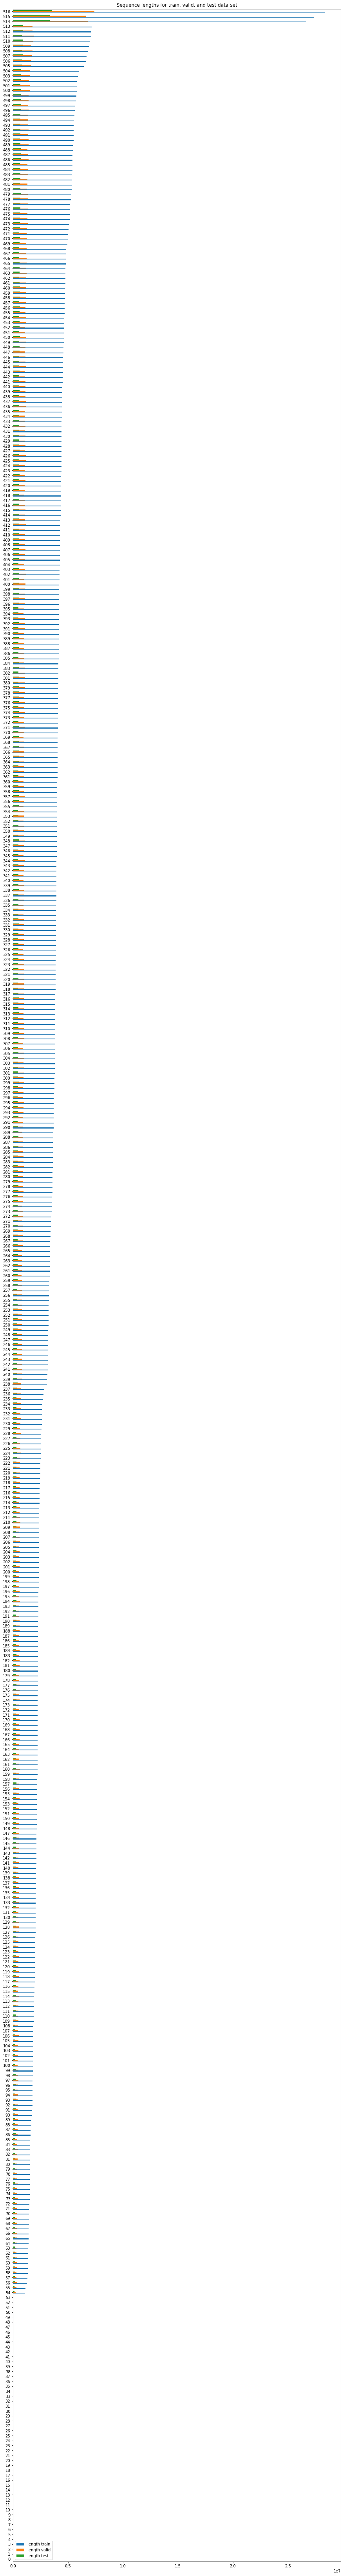

In [116]:
df_train_split.plot(kind='barh', figsize=(15,120), title='Sequence lengths for train, valid, and test data set');

# Test dataset (Test, NTC, and POS genomes)

In [4]:
PATH_CH1 = Path('Challenge_Data_Sets')
PATH_CH2 = Path('Challenge_Data_NTC_POS')

## Convert fastq files to csv

In [94]:
# Based on https://github.com/frenzymadness/FastQ_converter
def convert_fastq_to_csv(in_file, out_file):
    out_file.write(u'"id","sequence","quality"\n')
    for line in in_file:
        if not line.startswith('@'):
            continue
        seq_id = line.strip()
        sequence = next(in_file).strip()
        next(in_file)
        quality = next(in_file).strip()
        out_file.write(u'"{}","{}","{}"\n'.format(seq_id, sequence, quality))

In [95]:
# Based on https://github.com/frenzymadness/FastQ_converter
def batch_conv_fastq_to_csv(path, extensions=['.fq','.fastq']):
    for ext in extensions:
        fns = get_files(path, extension=ext)
        for fn in fns:
            fn_out = ''.join(fn.path.split(ext)[:-1])+'.csv'
            with open(fn) as infd:
                with open(fn_out, 'w') as outfd:
                    convert_fastq_to_csv(infd, outfd)

In [96]:
# convert fastq files to csv in PATH_CH1
batch_conv_fastq_to_csv(PATH_CH1)

In [97]:
# convert fastq files to csv in PATH_CH2
batch_conv_fastq_to_csv(PATH_CH2)

## EDA per fastq file

In [5]:
def get_fastq_eda(path, extensions=['.fq','.fastq'], hist=True,
                  score_long=False, score_short=False, score_n=50):
    '''
    Function to display information of fastq files from a directory.
    '''
    for ext in extensions:
        for f in get_files(path, extension=ext):
            seq, lbs, score = [], [], []
            for rec in SeqIO.parse(f, 'fastq'):
                seq.append(str(rec.seq.upper())) # append sequence
                lbs.append(str(rec.name)) # append sequence name
                score.append(rec.letter_annotations['phred_quality']) # append phred score
            
            df = pd.DataFrame({'label': lbs, 'sequence': seq, 'score': score}) # create df from the lists
            del seq, lbs, score # delete df to free up RAM
            
            assert df.isna().sum().sum() == 0 # check for NaN values
            #assert df.duplicated().sum() == 0 # check for duplicates
            
            print(f'{f.path} ({df.shape[0]} reads)') # print file path and read count
            
            df['length'] = df['sequence'].apply(lambda x: len(x)) # create length col with sequence lengths

            # check if sequence and score length match
            df['length_q'] = df['score'].apply(lambda x: len(x))
            df['check'] = ~(df['length'] == df['length_q']) # not(equal)
            assert df['check'].sum() == 0
            df = df.drop(['length_q','check'], axis=1) # remove cols to reduce df size after check
            
            # plot sequence length histogramm
            if not(score_long or score_short):
                plt.figure(figsize=(15,5))
                df['length'].plot(kind='hist', bins=100, figsize=(15,5), title=f'Sequence length histogram {f.name}');
            
            if (score_long and score_short):
                df = df.sort_values(by='length', ascending=False)            
            
            if score_long: # plot scores of longest sequences
                #df_plot = pd.concat((df_test.iloc[:50], df_test.iloc[-50:]), axis=0)

                plt.figure(figsize=(15,5))
                plt.title(f'Scores of longest {score_n} sequences {f.name}')
                for i, row in df.iloc[:score_n].iterrows():
                    plt.plot(row['score'], alpha=10/score_n)
                    
            if score_short: # plot scores of shortest sequences
                plt.figure(figsize=(15,5))
                plt.title(f'Scores of shortest {score_n} sequences {f.name}')
                for i, row in df.iloc[-score_n:].iterrows():
                    plt.plot(row['score'], alpha=10/score_n)

            #plt.figure(figsize=(15,5))
            #plt.title(f'Sequence scores {f.name}')
            #for i, row in df_plot.iterrows():
            #    plt.plot(row['score'], alpha=0.01)
            
            del df # delete df to free up RAM
            #return df

In [ ]:
get_fastq_eda(PATH_CH1)

Challenge_Data_Sets/C04_R1.fq (4000000 reads)
Challenge_Data_Sets/C08_R1.fq (5684638 reads)
Challenge_Data_Sets/C03_R2.fq (4000000 reads)
Challenge_Data_Sets/C05_R1.fq (4000000 reads)
Challenge_Data_Sets/C02_R1.fq (4000000 reads)
Challenge_Data_Sets/C06_R1.fq (4000000 reads)
Challenge_Data_Sets/C01_R1.fq (4000000 reads)
Challenge_Data_Sets/C07_R1.fq (5331259 reads)
Challenge_Data_Sets/C03_R1.fq (4000000 reads)
Challenge_Data_Sets/C01_R2.fq (4000000 reads)
Challenge_Data_Sets/C09_R2.fq (5965505 reads)
Challenge_Data_Sets/C06_R2.fq (4000000 reads)
Challenge_Data_Sets/C04_R2.fq (4000000 reads)
Challenge_Data_Sets/C08_R2.fq (5684638 reads)
Challenge_Data_Sets/C09_R1.fq (5965505 reads)
Challenge_Data_Sets/C07_R2.fq (5331259 reads)
Challenge_Data_Sets/C05_R2.fq (4000000 reads)
Challenge_Data_Sets/C02_R2.fq (4000000 reads)


In [ ]:
get_fastq_eda(PATH_CH1, hist=False, score_long=True, score_short=False)

In [ ]:
get_fastq_eda(PATH_CH1, hist=False, score_long=False, score_short=True)

Challenge_Data_NTC_POS/C20_R2.fastq (889480 reads)
Challenge_Data_NTC_POS/C17_R2.fastq (764908 reads)
Challenge_Data_NTC_POS/C16_R2.fastq (891992 reads)
Challenge_Data_NTC_POS/C21_R1.fastq (372105 reads)
Challenge_Data_NTC_POS/C18_R1.fastq (786779 reads)
Challenge_Data_NTC_POS/C18_R2.fastq (786779 reads)
Challenge_Data_NTC_POS/C16_R1.fastq (891992 reads)
Challenge_Data_NTC_POS/C21_R2.fastq (372105 reads)
Challenge_Data_NTC_POS/C17_R1.fastq (764908 reads)
Challenge_Data_NTC_POS/C20_R1.fastq (889480 reads)
Challenge_Data_NTC_POS/C19_R1.fastq (339458 reads)
Challenge_Data_NTC_POS/C19_R2.fastq (339458 reads)


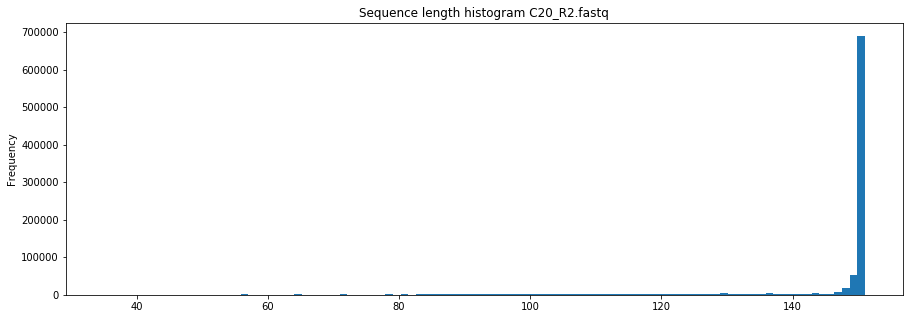

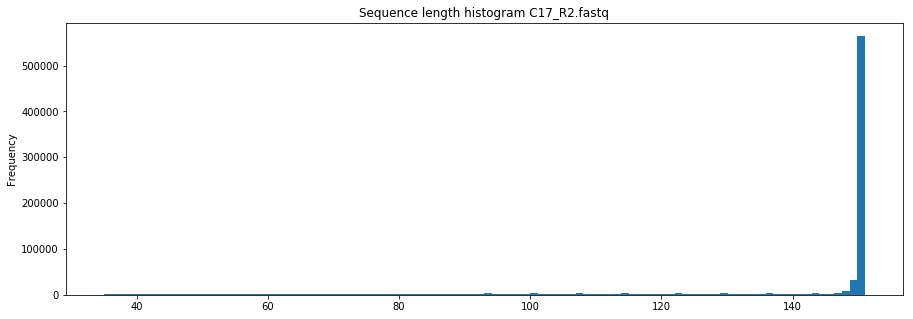

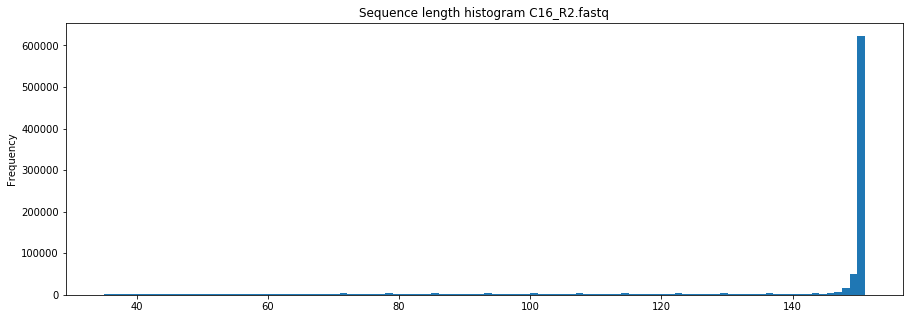

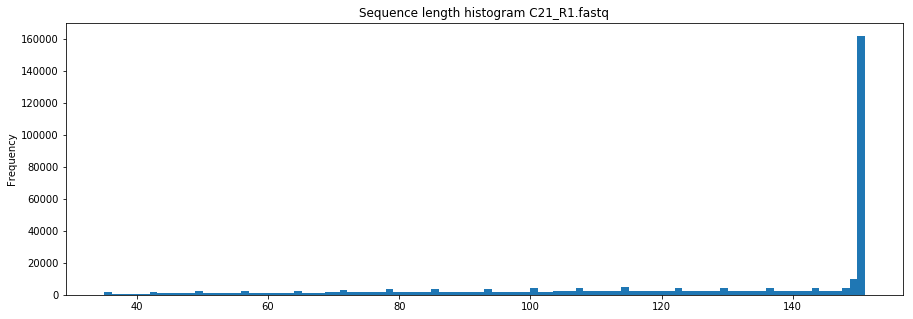

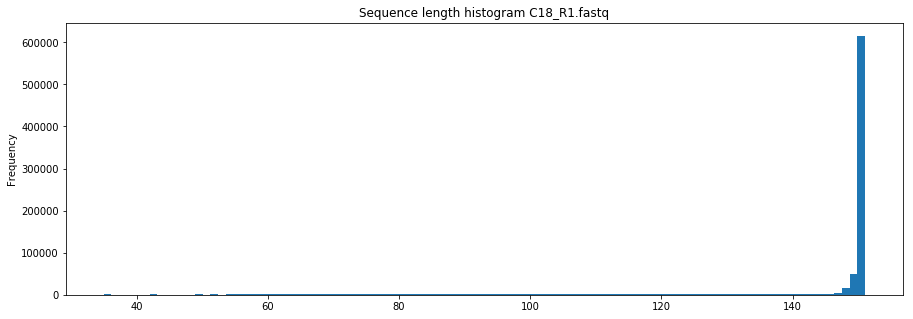

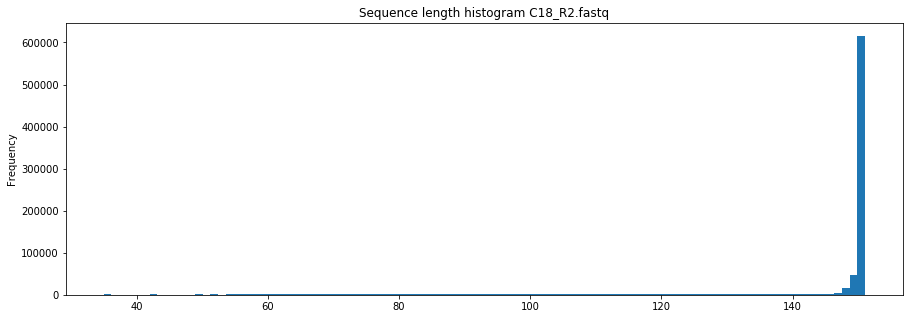

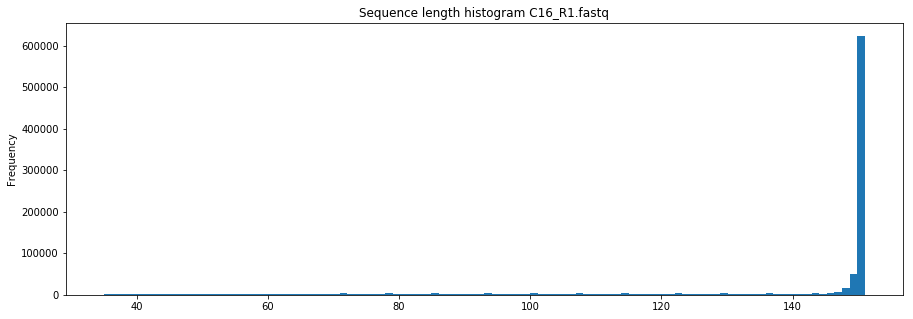

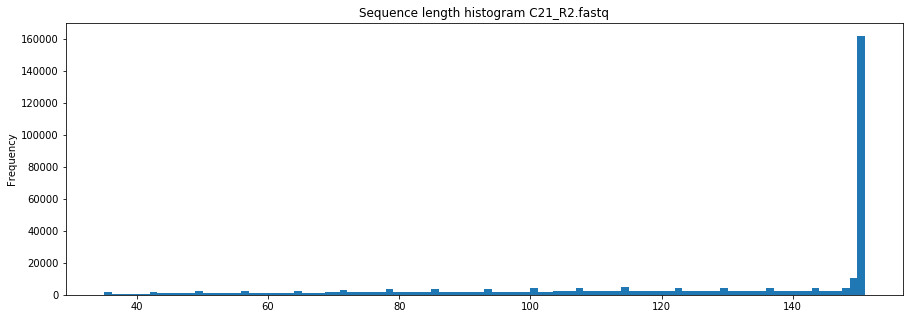

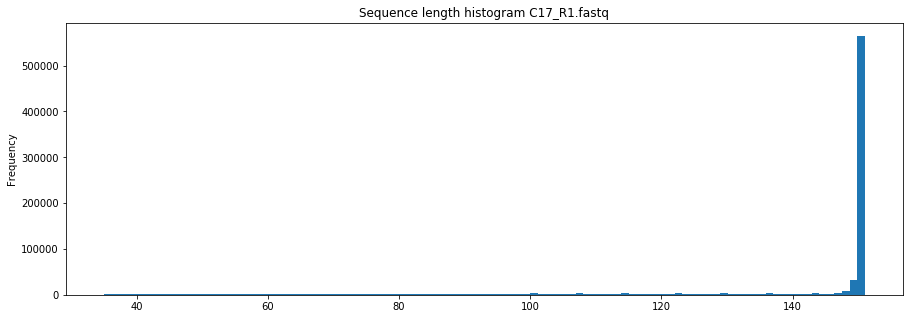

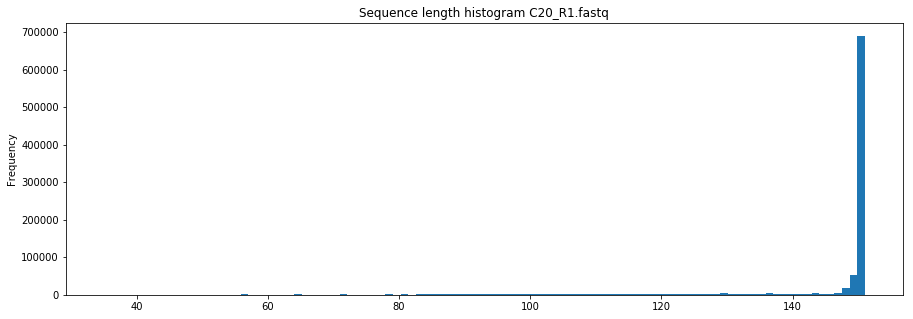

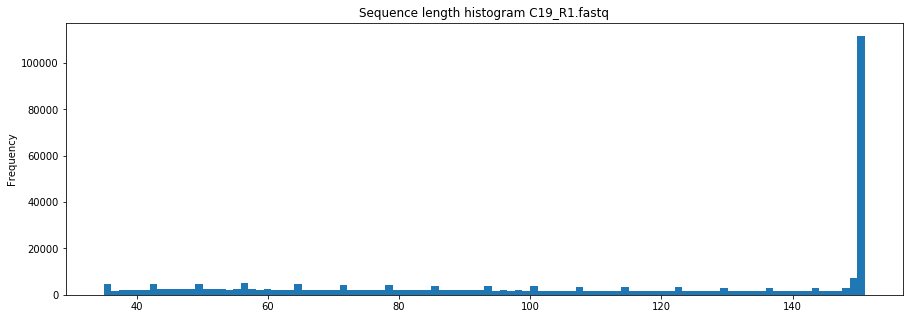

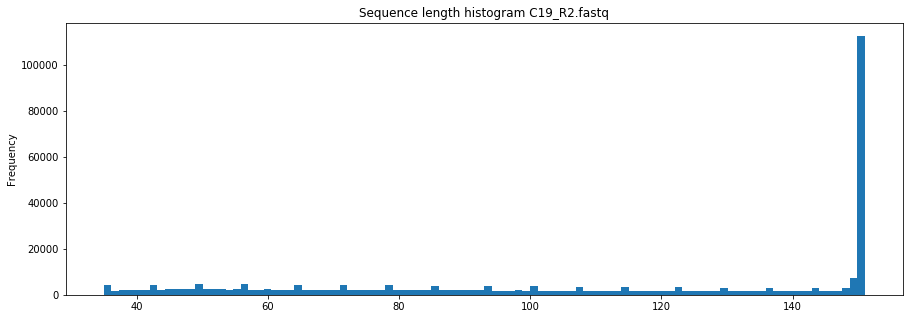

In [6]:
get_fastq_eda(PATH_CH2)

Challenge_Data_NTC_POS/C20_R2.fastq (889480 reads)
Challenge_Data_NTC_POS/C17_R2.fastq (764908 reads)
Challenge_Data_NTC_POS/C16_R2.fastq (891992 reads)
Challenge_Data_NTC_POS/C21_R1.fastq (372105 reads)
Challenge_Data_NTC_POS/C18_R1.fastq (786779 reads)
Challenge_Data_NTC_POS/C18_R2.fastq (786779 reads)
Challenge_Data_NTC_POS/C16_R1.fastq (891992 reads)
Challenge_Data_NTC_POS/C21_R2.fastq (372105 reads)
Challenge_Data_NTC_POS/C17_R1.fastq (764908 reads)
Challenge_Data_NTC_POS/C20_R1.fastq (889480 reads)
Challenge_Data_NTC_POS/C19_R1.fastq (339458 reads)
Challenge_Data_NTC_POS/C19_R2.fastq (339458 reads)


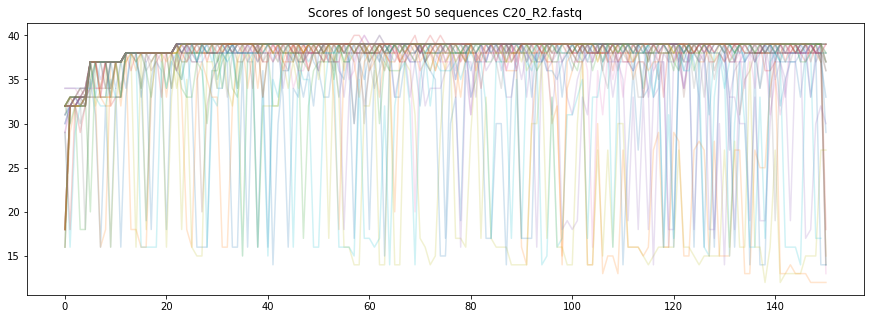

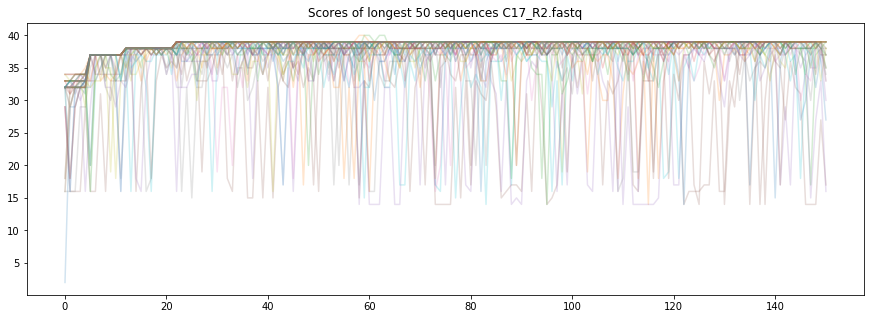

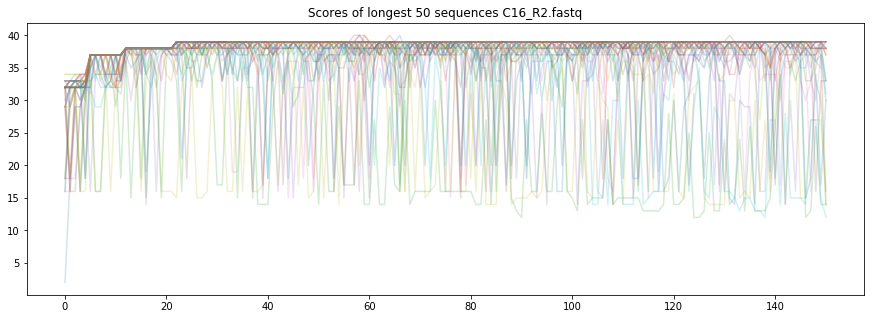

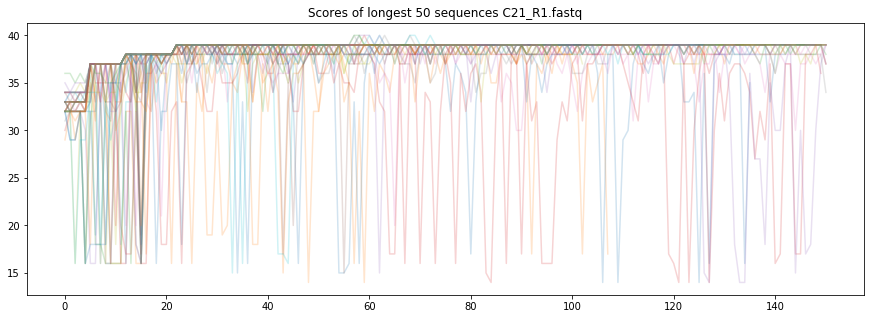

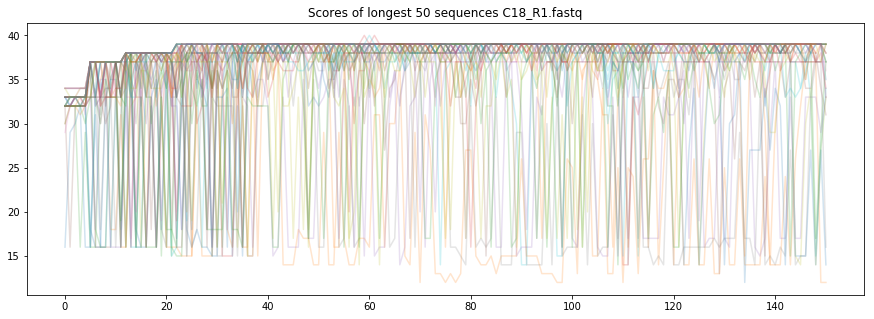

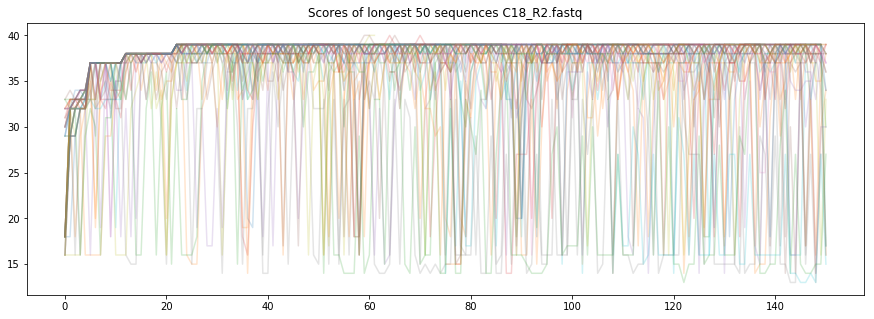

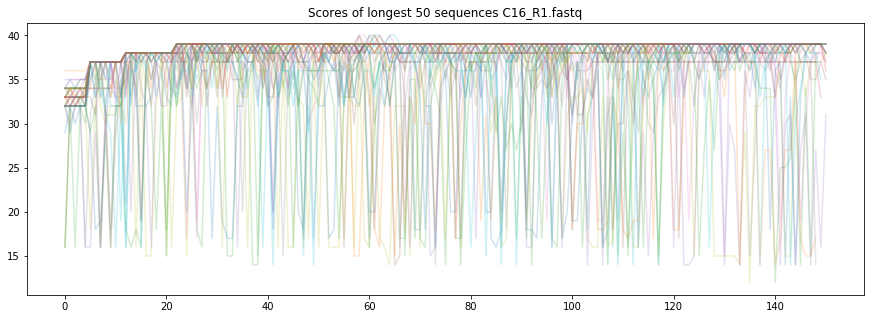

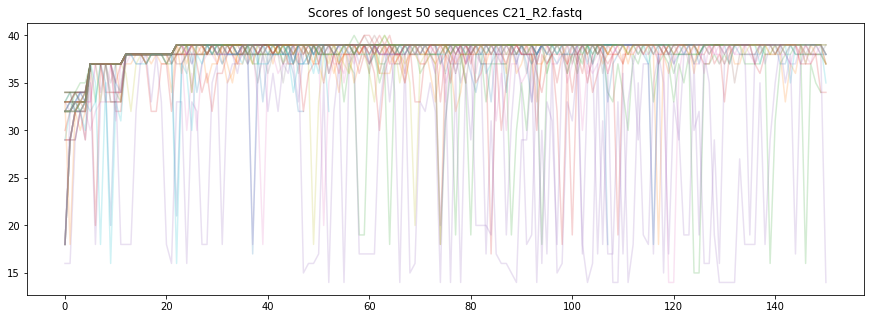

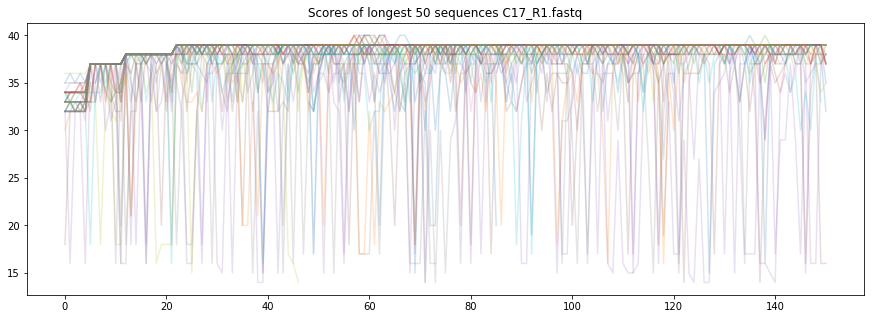

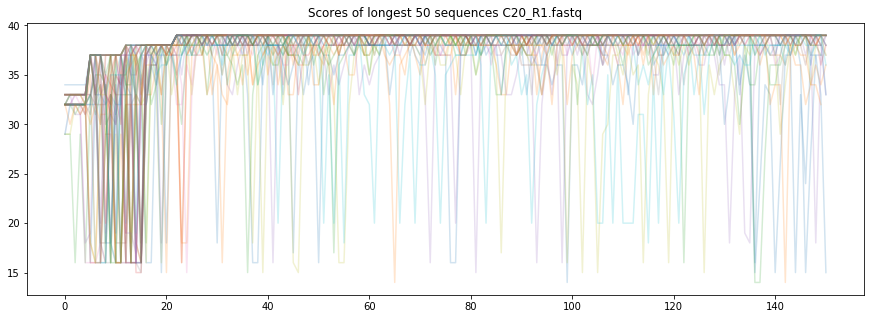

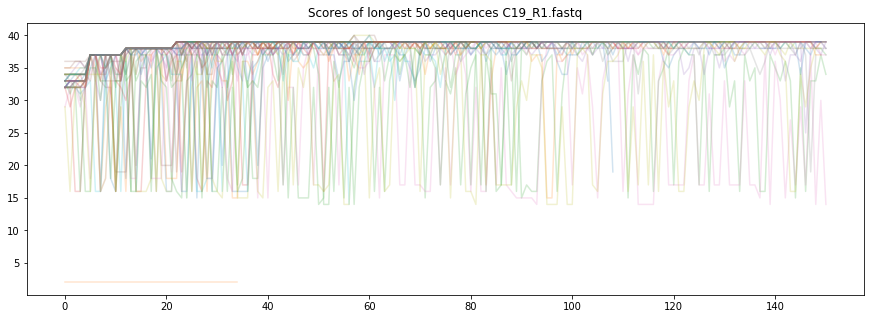

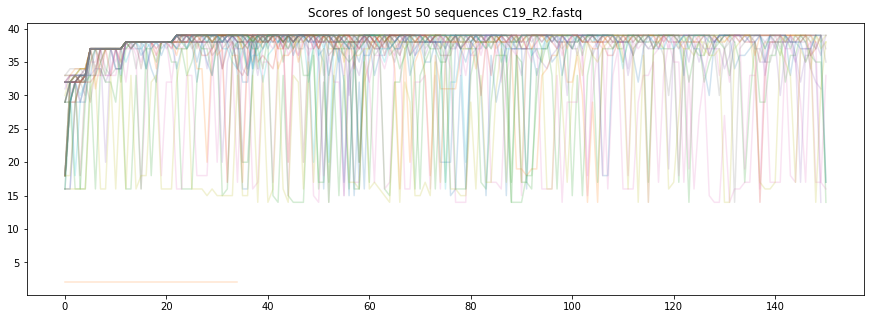

In [23]:
get_fastq_eda(PATH_CH2, hist=False, score_long=True, score_short=False)

Challenge_Data_NTC_POS/C20_R2.fastq (889480 reads)
Challenge_Data_NTC_POS/C17_R2.fastq (764908 reads)
Challenge_Data_NTC_POS/C16_R2.fastq (891992 reads)
Challenge_Data_NTC_POS/C21_R1.fastq (372105 reads)
Challenge_Data_NTC_POS/C18_R1.fastq (786779 reads)
Challenge_Data_NTC_POS/C18_R2.fastq (786779 reads)
Challenge_Data_NTC_POS/C16_R1.fastq (891992 reads)
Challenge_Data_NTC_POS/C21_R2.fastq (372105 reads)
Challenge_Data_NTC_POS/C17_R1.fastq (764908 reads)
Challenge_Data_NTC_POS/C20_R1.fastq (889480 reads)
Challenge_Data_NTC_POS/C19_R1.fastq (339458 reads)
Challenge_Data_NTC_POS/C19_R2.fastq (339458 reads)


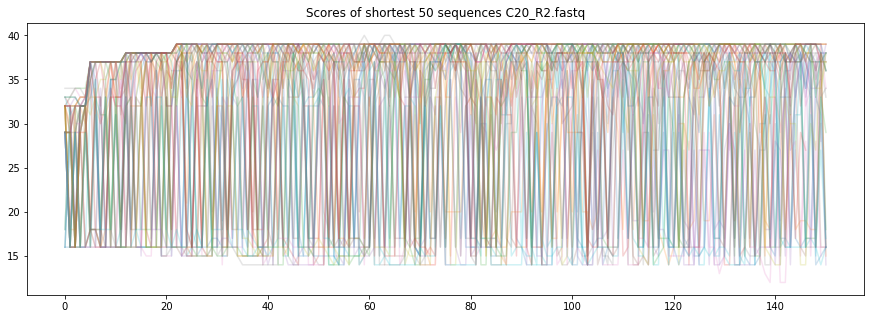

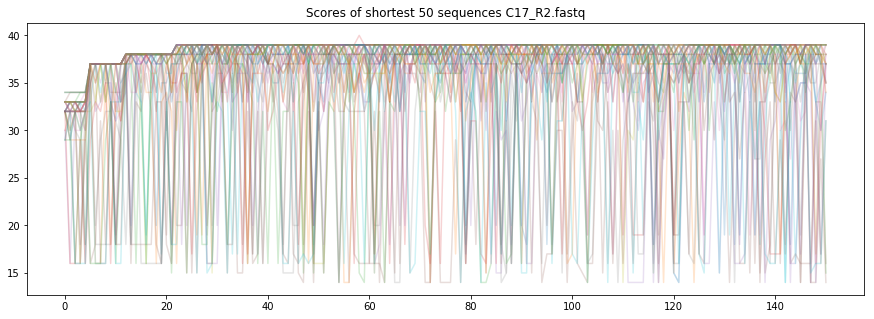

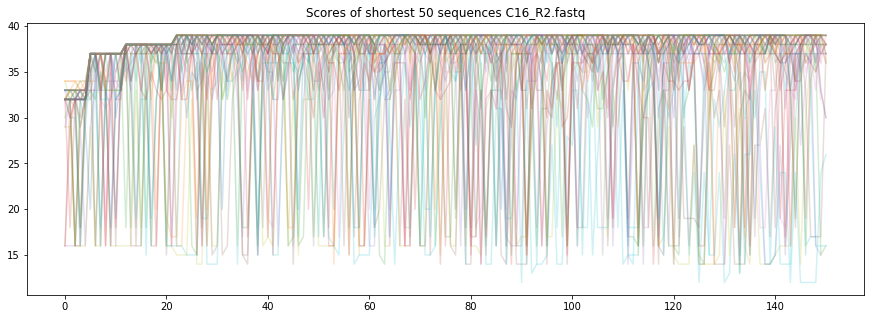

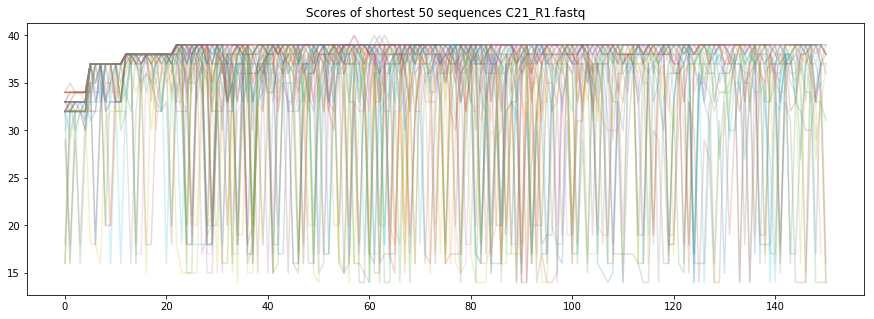

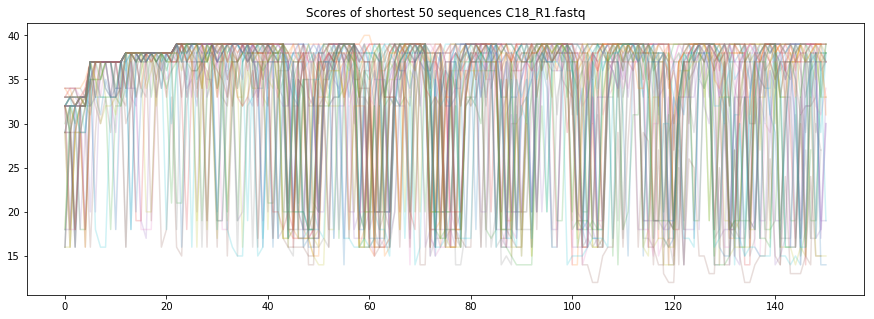

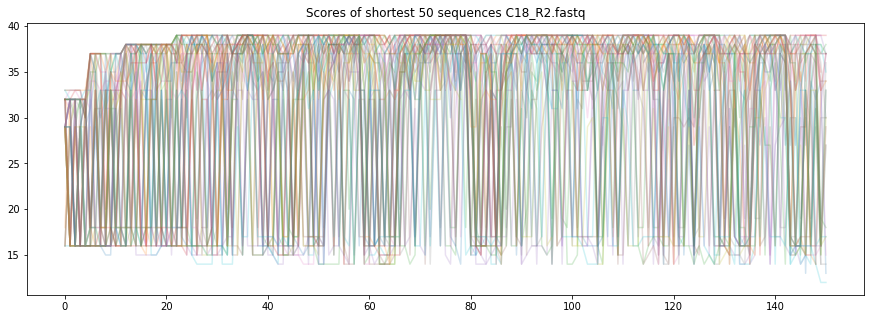

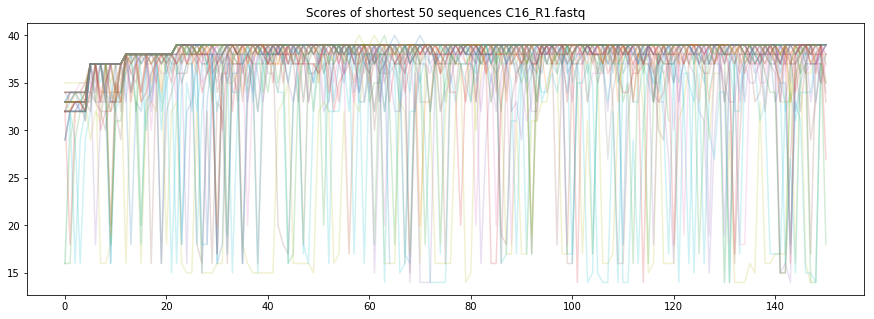

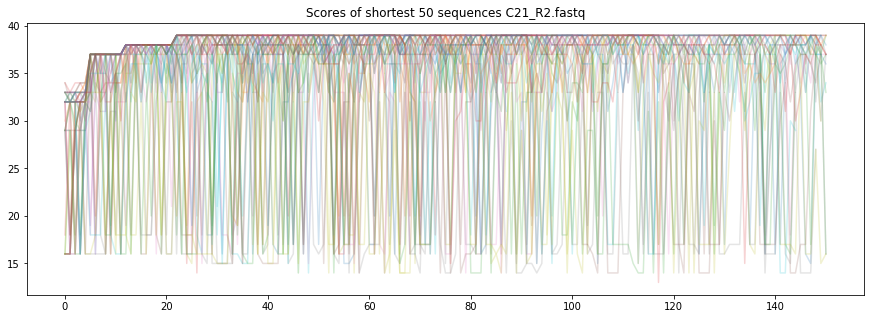

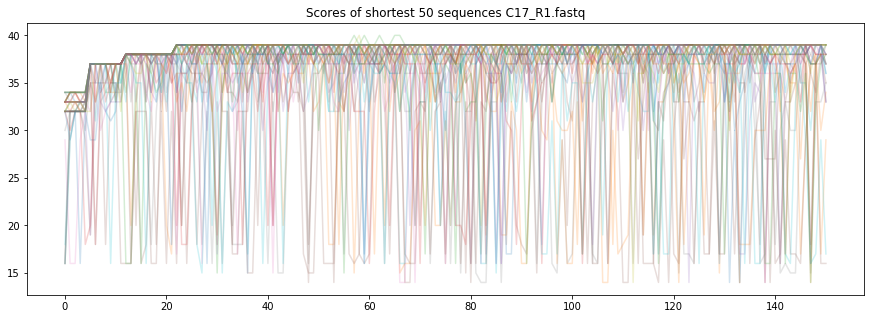

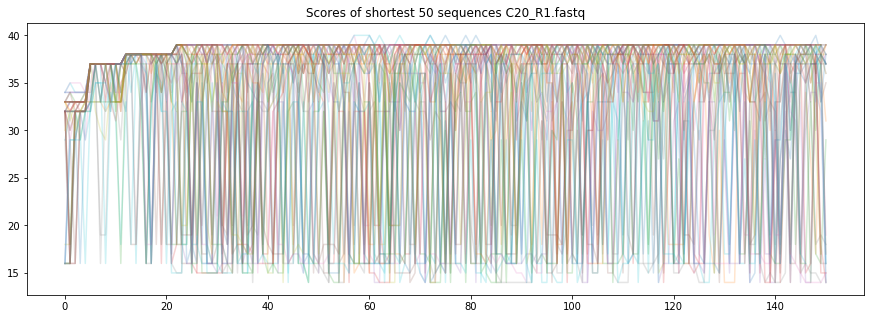

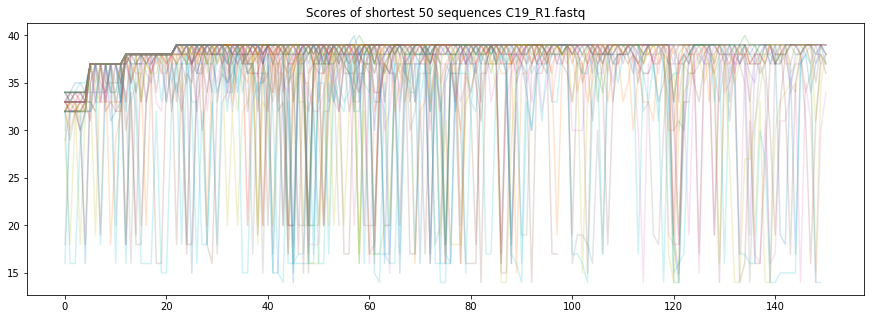

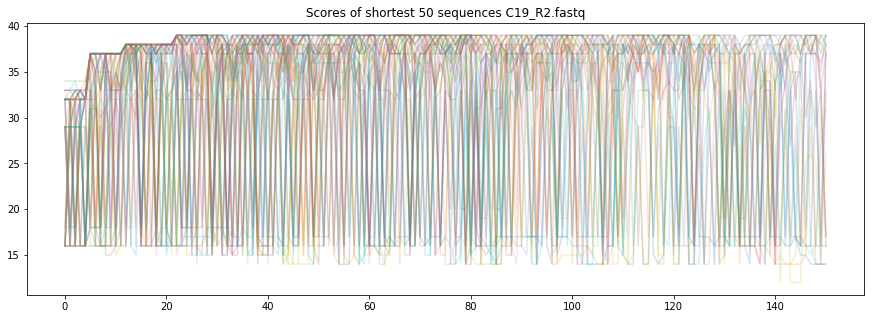

In [24]:
get_fastq_eda(PATH_CH2, hist=False, score_long=False, score_short=True)

# Data augmentation